# Data Map Construction for the Adult Dataset

This notebook guides you through the process of creating a **data map** based on training dynamics, as described in the paper *Dataset Cartography: Mapping and Diagnosing Datasets with Training Dynamics*. The goal is to compute **confidence** and **variability** for each training instance and visualize them in a 2D scatter plot.

## Step 1: Load the Adult Dataset

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

# Load dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame
df.head()

/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


## Step 2: Preprocess the Dataset

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Drop rows with missing values
df = df.replace('?', pd.NA).dropna()

# Encode categorical variables
df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.select_dtypes(include='category').columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Split features and labels
X = df_encoded.drop('class', axis=1)
y = le.fit_transform(df_encoded['class'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Step 3: Train Model and Capture Training Dynamics

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.net(x)

# Initialize model
model = SimpleNN(X_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track training dynamics
EPOCHS = 10
prob_history = np.zeros((len(X_train), EPOCHS))

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in dataloader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X_tensor), dim=1)
        prob_history[:, epoch] = probs[np.arange(len(y_train)), y_train]

## Step 4: Compute Confidence and Variability

In [4]:
confidence = prob_history.mean(axis=1)
variability = prob_history.std(axis=1)

## Step 4.1: Compute Correctness

In [5]:
# Correctness: fraction of epochs where the true label was predicted as the most probable
correct_predictions = np.argmax(prob_history, axis=2) if prob_history.ndim == 3 else (prob_history > 0.5).astype(int)
correctness = (correct_predictions == y_train.reshape(-1, 1)).mean(axis=1)


## Step 5: Plot the Data Map

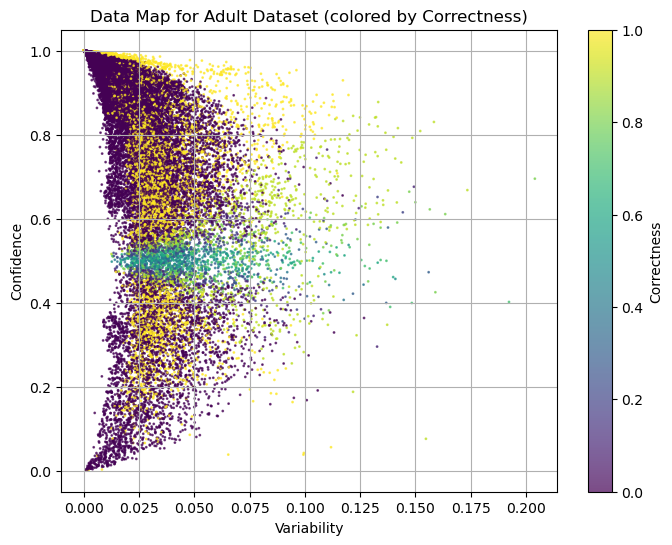

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(variability, confidence, c=correctness, cmap='viridis', alpha=0.7, s=1)
plt.xlabel('Variability')
plt.ylabel('Confidence')
plt.title('Data Map for Adult Dataset (colored by Correctness)')
cbar = plt.colorbar(scatter, label='Correctness')
plt.grid(True)
plt.show()

## Step 5.1: Interpreting the Data Map Regions

The data map provides insights into different types of training examples:

- **Easy-to-learn**: Instances with high confidence and low variability. These are consistently predicted correctly early in training.
- **Ambiguous**: Instances with high variability. The model's predictions fluctuate during training, indicating uncertainty.
- **Hard-to-learn**: Instances with low confidence and low variability. These are consistently predicted incorrectly, possibly due to label noise or inherent difficulty.

The color scale in the plot corresponds to **correctness**, i.e., how frequently the model predicted the correct label across epochs.


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


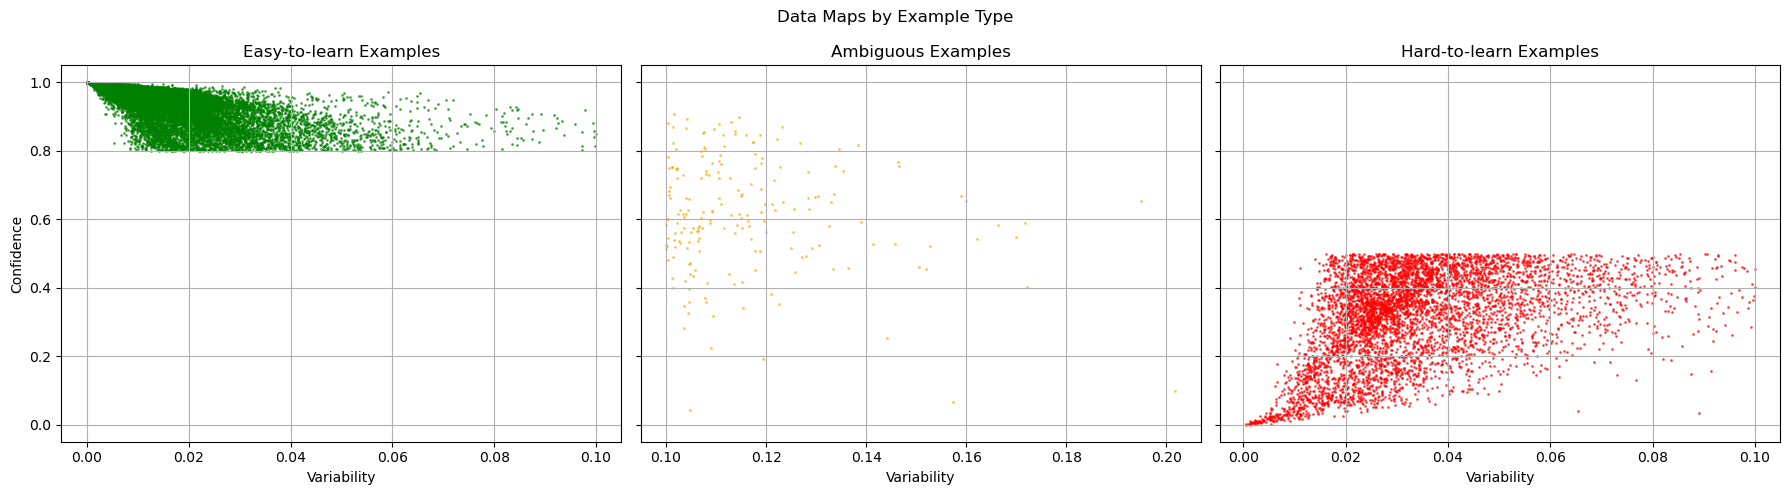

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess Adult dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
df = adult.frame
df = df.replace('?', pd.NA).dropna()

le = LabelEncoder()
for col in df.select_dtypes(include='category').columns:
    df[col] = le.fit_transform(df[col])

X = df.drop(columns='class')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Prepare PyTorch datasets
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.fc(x)

model = SimpleNN(X_tensor.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train and record training dynamics
EPOCHS = 10
prob_history = np.zeros((len(X_tensor), EPOCHS))

for epoch in range(EPOCHS):
    model.train()
    for xb, yb in dataloader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X_tensor), dim=1).numpy()
        prob_history[:, epoch] = probs[np.arange(len(y_tensor)), y_tensor.numpy()]

# Compute metrics
confidence = prob_history.mean(axis=1)
variability = prob_history.std(axis=1)
correctness = (prob_history > 0.5).astype(int).mean(axis=1)

# Masks for different types
easy_mask = (confidence > 0.8) & (variability < 0.1)
hard_mask = (confidence < 0.5) & (variability < 0.1)
ambiguous_mask = (variability >= 0.1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].scatter(variability[easy_mask], confidence[easy_mask], c='green', alpha=0.6, s=1)
axes[0].set_title('Easy-to-learn Examples')
axes[0].set_xlabel('Variability')
axes[0].set_ylabel('Confidence')
axes[0].grid(True)

axes[1].scatter(variability[ambiguous_mask], confidence[ambiguous_mask], c='orange', alpha=0.6, s=1)
axes[1].set_title('Ambiguous Examples')
axes[1].set_xlabel('Variability')
axes[1].grid(True)

axes[2].scatter(variability[hard_mask], confidence[hard_mask], c='red', alpha=0.6, s=1)
axes[2].set_title('Hard-to-learn Examples')
axes[2].set_xlabel('Variability')
axes[2].grid(True)

plt.suptitle('Data Maps by Example Type')
plt.tight_layout()
plt.show()


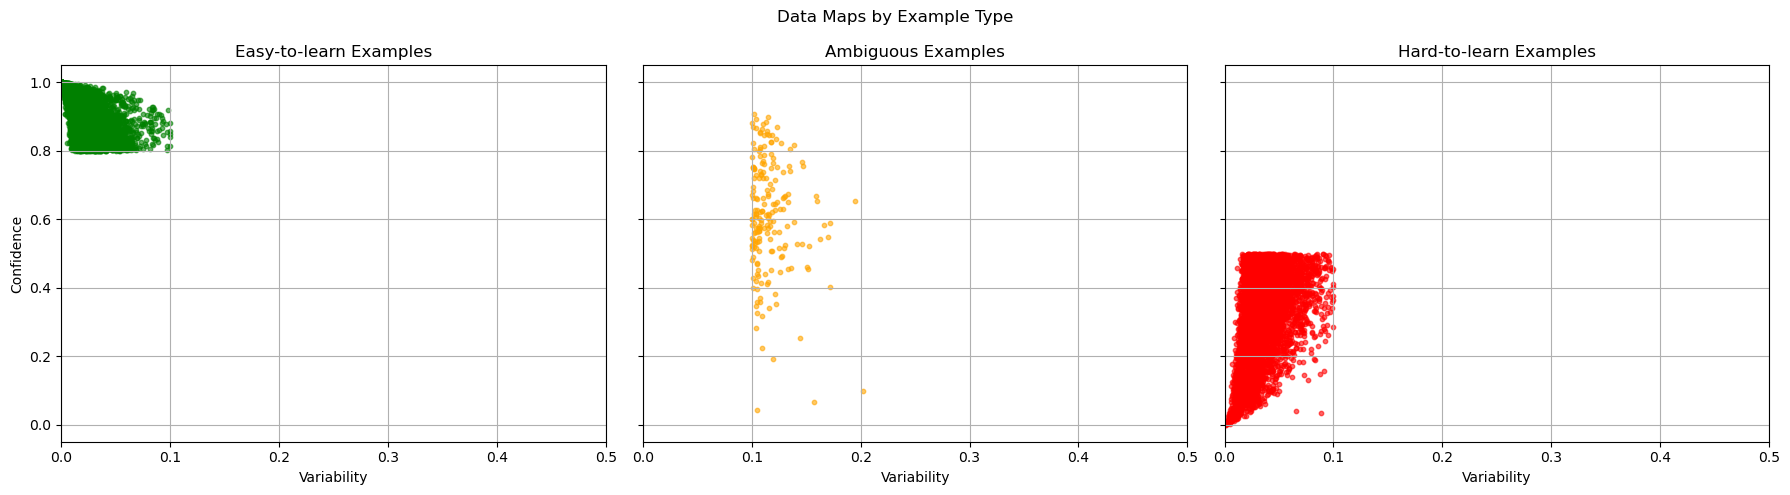

In [8]:
# Masks for different types
easy_mask = (confidence > 0.8) & (variability < 0.1)
hard_mask = (confidence < 0.5) & (variability < 0.1)
ambiguous_mask = (variability >= 0.1)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].scatter(variability[easy_mask], confidence[easy_mask], c='green', alpha=0.6, s=10)
axes[0].set_title('Easy-to-learn Examples')
axes[0].set_xlabel('Variability')
axes[0].set_ylabel('Confidence')
axes[0].set_xlim(0, 0.5)
axes[0].grid(True)

axes[1].scatter(variability[ambiguous_mask], confidence[ambiguous_mask], c='orange', alpha=0.6, s=10)
axes[1].set_title('Ambiguous Examples')
axes[1].set_xlabel('Variability')
axes[1].set_xlim(0, 0.5)
axes[1].grid(True)

axes[2].scatter(variability[hard_mask], confidence[hard_mask], c='red', alpha=0.6, s=10)
axes[2].set_title('Hard-to-learn Examples')
axes[2].set_xlabel('Variability')
axes[2].set_xlim(0, 0.5)
axes[2].grid(True)

plt.suptitle('Data Maps by Example Type')
plt.tight_layout()
plt.show()


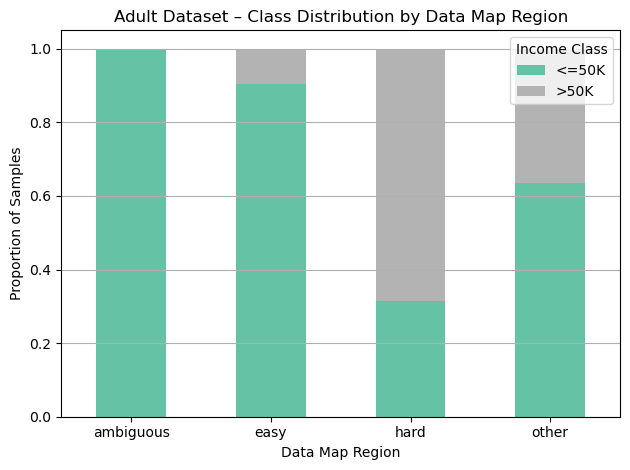

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define regions in the data map
easy_mask = (confidence > 0.8) & (variability < 0.1)
hard_mask = (confidence < 0.5) & (variability < 0.1)
ambiguous_mask = (variability > 0.2)

# Create DataFrame with regions and class labels
df_map = pd.DataFrame({
    "confidence": confidence,
    "variability": variability,
    "class": y_train,
    "region": "other"
})
df_map.loc[easy_mask, "region"] = "easy"
df_map.loc[ambiguous_mask, "region"] = "ambiguous"
df_map.loc[hard_mask, "region"] = "hard"

# Count and normalize class distribution in each region
region_class_counts = df_map.groupby(["region", "class"]).size().unstack(fill_value=0)
region_class_percent = region_class_counts.div(region_class_counts.sum(axis=1), axis=0)

# Plot normalized class distribution
region_class_percent.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Adult Dataset – Class Distribution by Data Map Region")
plt.xlabel("Data Map Region")
plt.ylabel("Proportion of Samples")
plt.xticks(rotation=0)
plt.legend(title="Income Class", labels=["<=50K", ">50K"])
plt.grid(axis="y")
plt.tight_layout()
plt.show()


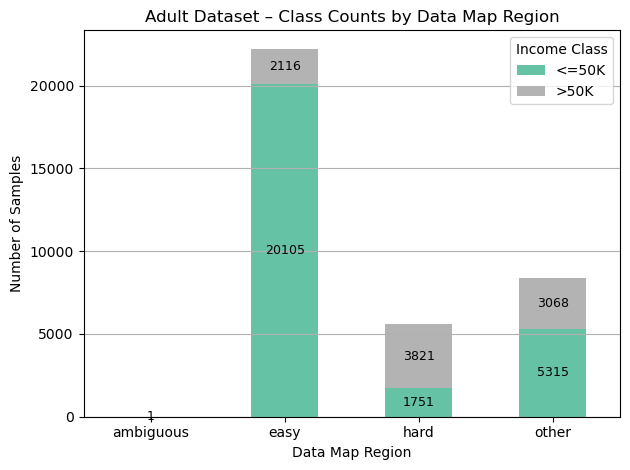

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define regiões no mapa
easy_mask = (confidence > 0.8) & (variability < 0.1)
hard_mask = (confidence < 0.5) & (variability < 0.1)
ambiguous_mask = (variability > 0.2)

# Cria DataFrame com as informações
df_map = pd.DataFrame({
    "confidence": confidence,
    "variability": variability,
    "class": y_train,
    "region": "other"
})
df_map.loc[easy_mask, "region"] = "easy"
df_map.loc[ambiguous_mask, "region"] = "ambiguous"
df_map.loc[hard_mask, "region"] = "hard"

# Contagem absoluta de exemplos por classe e região
region_class_counts = df_map.groupby(["region", "class"]).size().unstack(fill_value=0)

# Plotagem com anotações de valores
ax = region_class_counts.plot(kind="bar", stacked=True, colormap="Set2")
plt.title("Adult Dataset – Class Counts by Data Map Region")
plt.xlabel("Data Map Region")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.legend(title="Income Class", labels=["<=50K", ">50K"])
plt.grid(axis="y")

# Adiciona rótulos com contagens nas barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}", 
                    (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                    ha="center", va="center", fontsize=9, color="black")

plt.tight_layout()
plt.show()
